# Temporal overview sunset/sunrise<a class="tocSkip"></a>

_<a href= "mailto:alexander.dunkel@tu-dresden.de">Alexander Dunkel</a>, TU Dresden, Institute of Cartography;  Maximilian Hartmann, Universität Zürich (UZH), Geocomputation_

----------------

In [1]:
from IPython.display import Markdown as md
from datetime import date

today = date.today()
with open('/.version', 'r') as file: app_version = file.read().split("'")[1]
md(f"Last updated: {today.strftime('%b-%d-%Y')}, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version {app_version}")

Last updated: Sep-02-2022, [Carto-Lab Docker](https://gitlab.vgiscience.de/lbsn/tools/jupyterlab) Version 0.9.0

A brief look at the temporal distribution of the collected sunset/sunrise data.

# Preparations
## Load dependencies

This time, we use the [python_hll]() package to calculate hll set cardinalities.  
`python_hll` is significantly slower than the native Postgres HLL implementation.  
But there are only a few temporal HLL sets to calculate (year and months aggregates).

In [13]:
import sys
import pandas as pd
from pathlib import Path
from python_hll.hll import HLL
from python_hll.util import NumberUtil
module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools
from _03_chimaps import OUTPUT

## Load HLL aggregate data

Data is stored as aggregate HLL data (postcount) for each month.

In [3]:
root = Path.cwd().parents[1] / "00_hll_data"
SUNRISE_INSTAGRAM = root / "instagram-sunrise-months.csv"
SUNSET_INSTAGRAM = root / "instagram-sunset-months.csv"
SUNRISE_FLICKR = root / "flickr-sunrise-months.csv"
SUNSET_FLICKR = root / "flickr-sunset-months.csv"

Some statistics for these files:

In [4]:
%%time
data_files = {
    "SUNRISE_INSTAGRAM":SUNRISE_INSTAGRAM,
    "SUNSET_INSTAGRAM":SUNSET_INSTAGRAM,
    "SUNRISE_FLICKR":SUNRISE_FLICKR,
    "SUNSET_FLICKR":SUNSET_FLICKR,
    }
tools.display_file_stats(data_files)

name,SUNRISE_INSTAGRAM,SUNSET_INSTAGRAM,SUNRISE_FLICKR,SUNSET_FLICKR
size,20.14 KB,19.12 KB,359.84 KB,359.87 KB
records,36,27,145,145


CPU times: user 692 ms, sys: 29.2 ms, total: 721 ms
Wall time: 2.48 s


Preview CSV:

In [5]:
df = pd.read_csv(SUNSET_FLICKR, nrows=10)

In [6]:
display(df)

,year,month,post_hll
0,2007,1,\x148b7f10c4218c43188e42144110c8810425298a228c...
1,2007,2,\x148b7f1946118822390412886118484294a530442188...
2,2007,3,\x148b7f188621904221084110a111c261908121025208...
3,2007,4,\x148b7f108a41046629ce520882308a309042194e23a5...
4,2007,5,\x148b7f11443108441106329845188424186220842298...
5,2007,6,\x148b7f294831908428ca2214853088518cc13050721c...
6,2007,7,\x148b7f10c83290e4210a510c842110518ca31144320c...
7,2007,8,\x148b7f2086610ca431043208831084620847298a318c...
8,2007,9,\x148b7f310a420cc218cc418c8629ca528ce73146519c...
9,2007,10,\x148b7f210c6109022148310c662042310864390a4114...


# Calculate HLL Cardinality per month

**Prepare functions**

These functions were first used in the [YFCC HLL Workshop](https://ad.vgiscience.org/mobile_cart_workshop2020/02_hll_intro.html).

In [7]:
def hll_from_byte(hll_set: str):
    """Return HLL set from binary representation"""
    hex_string = hll_set[2:]
    return HLL.from_bytes(
        NumberUtil.from_hex(
            hex_string, 0, len(hex_string)))

def cardinality_from_hll(hll_set):
    """Turn binary hll into HLL set and return cardinality"""
    hll = hll_from_byte(hll_set)
    return hll.cardinality() - 1

Define additional functions for reading and formatting CSV as `pd.DataFrame`

In [8]:
def read_csv_datetime(csv: Path) -> pd.DataFrame:
    """Read CSV with parsing datetime index (months)
    
        First CSV column: Year
        Second CSV column: Month
    """
    date_cols = ["year", "month"]
    df = pd.read_csv(
        csv, index_col='datetime', 
        parse_dates={'datetime':date_cols},
        date_parser=lambda x: pd.datetime.strptime(x, '%Y %m'),
        keep_date_col='False')
    df.drop(columns=date_cols, inplace=True)
    return df
    
def append_cardinality_df(df: pd.DataFrame, hll_col: str = "post_hll"):
    """Calculate cardinality from HLL and append to extra column in df"""
    df['postcount_est'] = df.apply(
        lambda x: cardinality_from_hll(
           x[hll_col]),
        axis=1)
    df.drop(columns=["post_hll"], inplace=True)
    return df

def filter_fill_time(
        df: pd.DataFrame, min_year: int, 
        max_year: int, val_col: str = "postcount_est"):
    """Filter time values between min - max year and fill missing values"""
    min_date = pd.Timestamp(f'{min_year}-01-01')
    max_date = pd.Timestamp(f'{max_year}-01-01')
    # clip by start and end date
    if not min_date in df.index:
        df.loc[min_date, val_col] = 0
    if not max_date in df.index:
        df.loc[min_date, val_col] = 0
    df.sort_index(inplace=True)
    # mask min and max time
    time_mask = ((df.index >= min_date) & (df.index <= max_date))
    # fill missing months with 0
    # this will also set the day to max of month
    series = df.loc[time_mask][val_col].resample('M').sum().fillna(0)
    return series.to_frame()

Apply functions to all data sets.
- Read from CSV
- calculate cardinality
- merge year and month to single column
- filter 2007 - 2018 range, fill missing values

In [9]:
%%time
import warnings; warnings.simplefilter('ignore')
dfs = {}
for key, data in data_files.items():
    df = read_csv_datetime(data)
    df = append_cardinality_df(df)
    df = filter_fill_time(df, 2007, 2018)
    dfs[key] = df

CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.8 s


<details><summary><strong>RuntimeWarning?</strong> </summary>
    <div style="width:500px"><ul>
        <li><a href="https://github.com/AdRoll/python-hll">python-hll library</a> is in a very early stage of development</li>  
        <li>it is not fully compatible with the <a href="https://github.com/citusdata/postgresql-hll">citus hll implementation</a> in postgres</li> 
        <li>The shown <a href="https://tech.nextroll.com/blog/dev/2019/10/01/hll-in-python.html">RuntimeWarning (Overflow)</a> is one of the issues that need to be resolved in the future</li>
        <li>If you run this notebook locally, it is recommended to use <a href="https://gitlab.vgiscience.de/lbsn/databases/pg-hll-empty">pg-hll-empty</a> for
        any hll calculations, as is shown (e.g.) in the original <a href="https://gitlab.vgiscience.de/ad/yfcc_gridagg">YFCC100M notebooks</a>.</li>
        <li>There is no significant negative impact on accuracy for this application case.</li>
        </ul>
</div>
</details>

In [10]:
dfs["SUNRISE_FLICKR"].head(5)

,postcount_est
datetime,
2007-01-31,2787
2007-02-28,2300
2007-03-31,3386
2007-04-30,2630
2007-05-31,2407


# Visualize Cardinality

Define plot function.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.axes import Axes 
from matplotlib import cm
from typing import Tuple

def bar_plot_time(
        df: pd.DataFrame, ax: Axes, color: str, label: str,
        val_col: str = "postcount_est") -> Axes:
    """Matplotlib Barplot with time axis formatting"""
    ax = df.set_index(
        df.index.map(lambda s: s.strftime('%Y'))).plot.bar(
            ax=ax, y="postcount_est", color=color, width=1.0,
            label=label, edgecolor="white", linewidth=0.5, alpha=0.8)
    return ax

def plot_time(dfs: Tuple[pd.DataFrame, pd.DataFrame], title, filename = None, output = OUTPUT):
    """Create dataframe(s) time plot"""
    fig, ax = plt.subplots()
    fig.set_size_inches(15.7, 4.27)
    # get color
    colors = sns.color_palette("vlag", as_cmap=True, n_colors=2)
    # sunset
    ax = bar_plot_time(
        df=dfs[0], ax=ax, color=colors([1.0]), label="Sunset")
    # sunrise
    ax = bar_plot_time(
        df=dfs[1], ax=ax, color=colors([0.0]), label="Sunrise")
    # x axis ticker formatting
    tick_loc = mticker.MultipleLocator(12)
    ax.xaxis.set_major_locator(tick_loc)
    ax.tick_params(axis='x', rotation=45)
    ax.ticklabel_format(axis='y', style='plain')
    ax.set(xlabel="Month", ylabel="Post Count (estimate)")
    ax.spines["left"].set_linewidth(0.25)
    ax.spines["bottom"].set_linewidth(0.25)
    ax.spines["top"].set_linewidth(0)
    ax.spines["right"].set_linewidth(0)
    ax.yaxis.set_tick_params(width=0.5)
    # add legend
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title)
    # store figure to file
    if filename:
        fig.savefig(
            output / "figures" / f"{filename}.png", dpi=300, format='PNG',
            bbox_inches='tight', pad_inches=1, facecolor="white")
        # also save as svg
        fig.savefig(
            output / "svg" / f"{filename}.svg", format='svg',
            bbox_inches='tight', pad_inches=1, facecolor="white")

Plot sunset and sunrise for both Instagram and Flickr collected data.

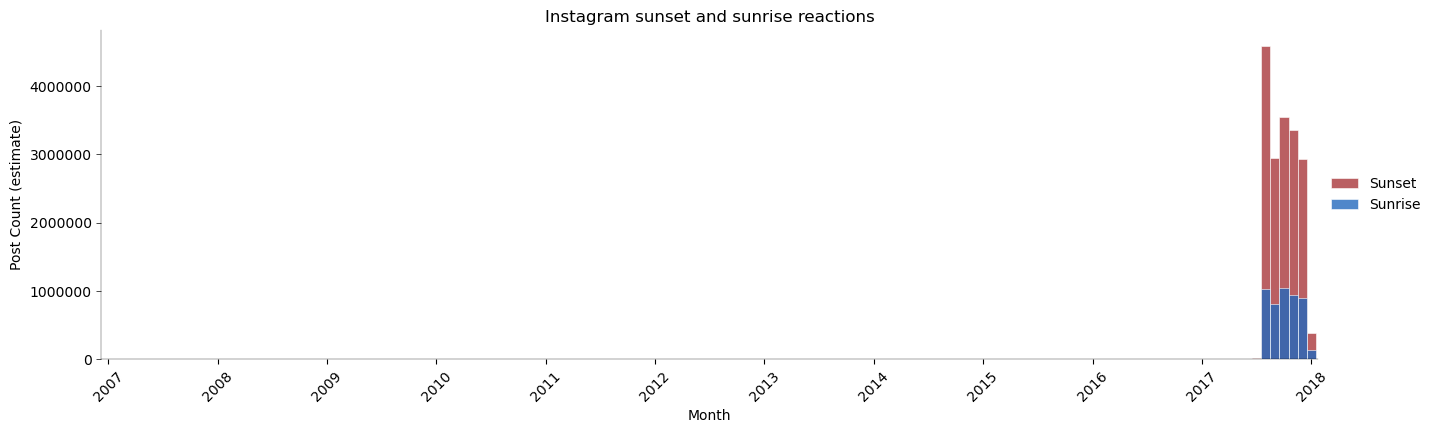

In [15]:
plot_time(
    dfs = (dfs["SUNSET_INSTAGRAM"], dfs["SUNRISE_INSTAGRAM"]),
    title='Instagram sunset and sunrise reactions', 
    filename="temporal_analysis_instagram")

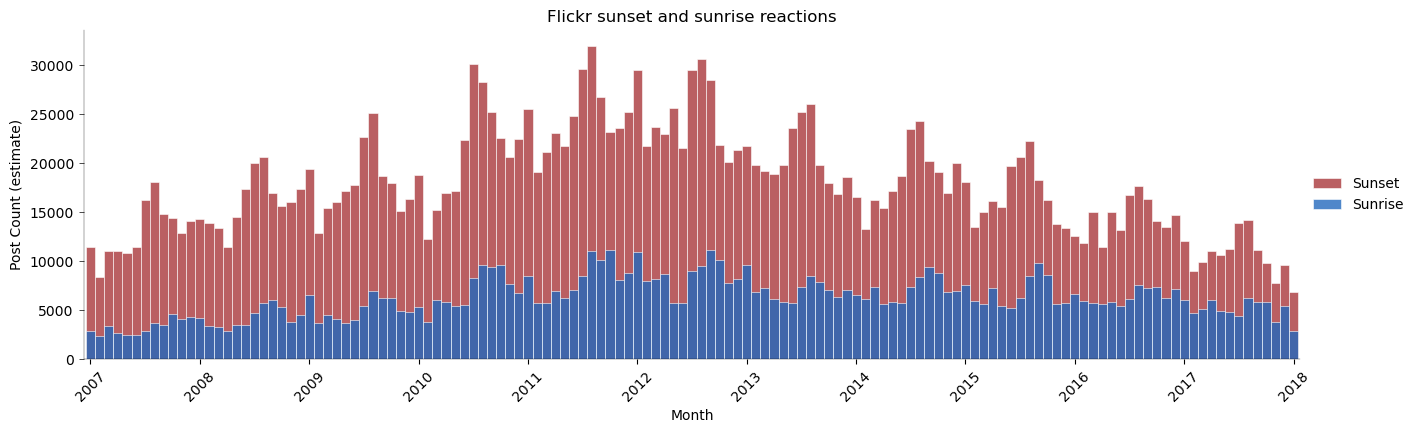

In [16]:
plot_time(
    dfs = (dfs["SUNSET_FLICKR"], dfs["SUNRISE_FLICKR"]),
    title='Flickr sunset and sunrise reactions', 
    filename="temporal_analysis_flickr")

# Create notebook HTML

In [19]:
!jupyter nbconvert --to html_toc \
    --output-dir=../out/html ./07_time.ipynb \
    --template=../nbconvert.tpl \
    --ExtractOutputPreprocessor.enabled=False >&- 2>&- # create single output file

Copy single HTML file to resource folder

In [20]:
!cp ../out/html/07_time.html ../resources/html/